## Limits of diversification



### Contents
- Import of python modules
- Data Import & processing
- Construction of the total market index 
- Correlation Analysis
- Conclusion

### 1. Import of python modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from utils import *
from portfolio_stats import *

%matplotlib inline

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Connect pandas DataFrame to plotly
import cufflinks as cf

# Make plotly work in jupyter notebook... In case of using juoyter lab, you will maybe need to install the plotly extension
# By using this command 'jupyter labextension install jupyterlab-plotly'
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Use plotly offline
cf.go_offline()

### 2. Data Import & Processing...

The following data that i used in this study come from: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
  - ind30_m_vw_rets : 30 portfolios industry returns from 1926 to 2018 --
  - ind30_m_nfirms : Number of firms that composed each industry from 1926 to 2018 -- 
  - ind30_m_size : Average size of firms that composed each industry from 1926 to 2018 -- 

In [2]:
# Monthly market cap value-weighted returns of 30 industries from Ken Fren data library
industries_ret = pd.read_csv('Data/ind30_m_vw_rets.csv', header=0, index_col=0,
                             parse_dates=True)/100
industries_ret.index = pd.to_datetime(industries_ret.index, format="%Y%m").to_period('M')
industries_ret.index.name = 'Date'
industries_ret.columns = industries_ret.columns.str.strip() # Get clean columns names without blank spaces

# Monthly industry size from Ken Fren data library
industries_avg_size = pd.read_csv('Data/ind30_m_size.csv', header=0, index_col=0,
                             parse_dates=True)
industries_avg_size.index = pd.to_datetime(industries_avg_size.index, format="%Y%m").to_period('M')
industries_avg_size.index.name = 'Date'
industries_avg_size.columns = industries_avg_size.columns.str.strip()

# Monthly number of firms in each industry from Ken Fren data library
industries_nfirms = pd.read_csv('Data/ind30_m_nfirms.csv', header=0, index_col=0,
                             parse_dates=True)
industries_nfirms.index = pd.to_datetime(industries_nfirms.index, format="%Y%m").to_period('M')
industries_nfirms.index.name = 'Date'
industries_nfirms.columns = industries_nfirms.columns.str.strip()

In [5]:
industries_ret.shape, industries_nfirms.shape, industries_avg_size.shape

((1110, 30), (1110, 30), (1110, 30))

In [6]:
industries_avg_size.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21
1926-10,37.14,8.92,64.42,28.76,14.42,21.23,19.03,26.87,68.47,6.82,...,364.16,15.30,59.52,34.77,70.83,0.88,46.15,10.80,19.36,26.16
1926-11,35.88,8.62,65.08,27.38,15.79,20.14,19.03,26.54,65.06,6.84,...,363.74,14.89,58.74,32.80,68.75,0.74,45.03,10.33,18.35,23.94


In [7]:
industries_nfirms.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1926-07,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-08,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-09,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-10,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4
1926-11,43,3,16,7,2,8,12,7,17,13,...,5,3,7,6,74,2,33,6,12,4


### 3. Construction of a total market index...

The goal is to look at what happens to correlation across stocks in the market in a severe market downturn. To do so, we assume a highly diversified market index made of the 30 US industries data from Ken French data library. The construction of the total market index is aligned with what is done for the S&P 500 index i.e that returns of industries will be weighted by their market capitalization. 

In [8]:
# Market capitalization of each industry
industries_mkt_cap = industries_nfirms*industries_avg_size
# Total market capitalization
total_mkt_cap = industries_mkt_cap.sum(axis='columns')
# Industries weights function of their market capitalization
industries_mkt_weights = industries_mkt_cap.divide(total_mkt_cap, axis = 'rows')
# Total market index returns
total_mkt_returns = (industries_mkt_weights * industries_ret).sum(axis='columns')

In [9]:
# Check of weights that must be added up to 1
all(industries_mkt_weights.sum(axis='columns')) == 1

True

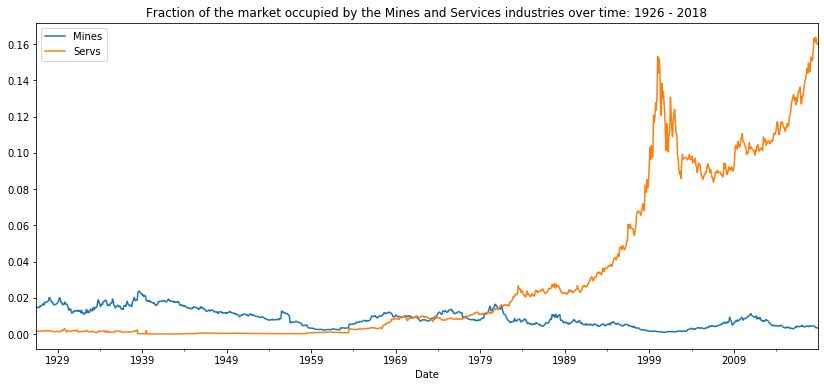

In [10]:
industries_mkt_weights[["Mines", "Servs"]].plot(figsize=(14,6), 
                                                title='Fraction of the market occupied by the Mines and Services industries over time: 1926 - 2018')

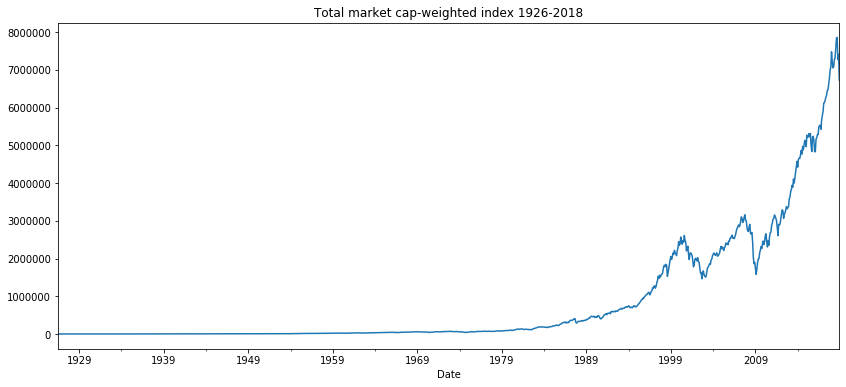

In [11]:
total_market_index = 1000*(1+((industries_mkt_weights * industries_ret).sum(axis='columns'))).cumprod()
total_market_index.plot(figsize=(14,6), title='Total market cap-weighted index 1926-2018')

### 4. Correlation Analysis...

##### How returns are related to stocks' correlation (on a 36 months window) over time? 

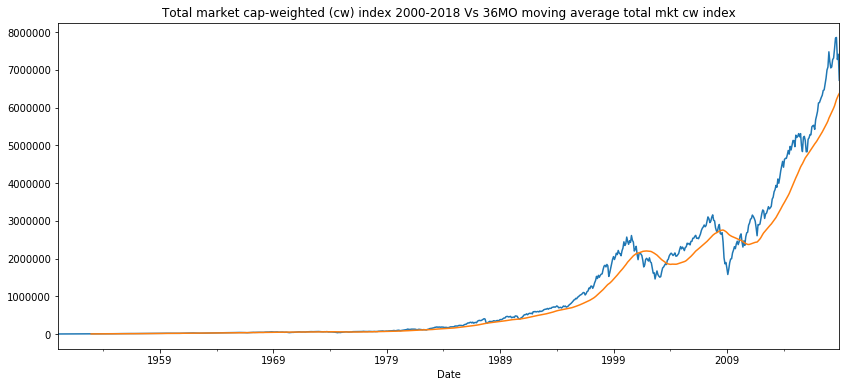

In [12]:
tmi_36mo = total_market_index['1950':].rolling(window=36).mean()
total_market_index['1950':].plot(figsize=(14,6), title='Total market cap-weighted (cw) index 2000-2018 Vs 36MO moving average total mkt cw index')
tmi_36mo.plot()

Here is the correlation through time, across the industries that constitue the market index. The correlation is computed on a span of 36 months (3 years). 

In [13]:
corr_ret36mo = industries_ret.rolling(window=36).corr().dropna()
corr_ret36mo.index.names = ['Date', 'Industry']
corr_ret36mo

Food      Beer     Smoke     Games     Books     Hshld  \
Date    Industry                                                               
1929-06 Food      1.000000  0.629628  0.596971  0.675709  0.281427  0.729475   
        Beer      0.629628  1.000000  0.346617  0.328484  0.349330  0.458642   
        Smoke     0.596971  0.346617  1.000000  0.317146  0.086412  0.424323   
        Games     0.675709  0.328484  0.317146  1.000000  0.198889  0.715495   
        Books     0.281427  0.349330  0.086412  0.198889  1.000000  0.174562   
...                    ...       ...       ...       ...       ...       ...   
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
Date    Industry                                          ...             
1929-06 Food      0.490230  0.676560  0.716603  0.617928  ...  0.623219   
        Beer      0.203686  0.532148  0.444421  0.640713  ...  0.426311   
        Smoke     0.155380  0.398125  0.452359  0.601743  ...  0.299186   
        Games     0.303105  0.513858  0.642301  0.439412  ...  0.550541   
        Books     0.435561  0.364148  0.114258  0.174108  ...  0.282757   
...                    ...       ...       ...       ...  ...       ...   
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
Date    Industry                                                               
1929-06 Food      0.497310  0.660446  0.643028  0.735555  0.444707  0.795404   
        Beer      0.281562  0.350989  0.504010  0.504435  0.516265  0.426823   
        Smoke     0.337226  0.428761  0.192498  0.563923  0.254963  0.519246   
        Games     0.406675  0.319347  0.350967  0.529214  0.287682  0.534292   
        Books     0.139979  0.189726  0.308485  0.252343  0.028740  0.238301   
...                    ...       ...       ...       ...       ...       ...   
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
Date    Industry                                
1929-06 Food      0.684892  0.712037  0.724775  
        Beer      0.498461  0.526614  0.468640  
        Smoke     0.244318  0.461119  0.490210  
        Games     0.397446  0.663349  0.567514  
        Books     0.319734  0.293167  0.465276  
...                    ...       ...       ...  
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[32250 rows x 30 columns]

Let's not forget that we want to be able to compare the evolution of the diversified market index return to the evolution of the industries correlation in order to assess the relevancy of diversification in case of severe bear market. To do so, we will examine the average of the correlation of industries over a 36-month period each time and the compounded returns over 36 months, all over the period from 2000 to 2018. 

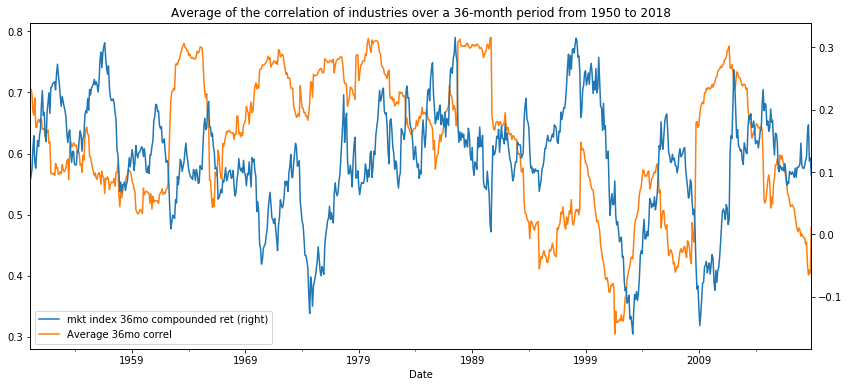

In [14]:
corr_ret36mo = corr_ret36mo.groupby(by='Date').apply(lambda mat: mat.values.mean())
mkt_36mo_compounded_ret = total_mkt_returns.rolling(window=36).aggregate(annualized_return, period_per_year=12)
mkt_36mo_compounded_ret['1950':].plot(secondary_y=True, figsize=(14,6), label='mkt index 36mo compounded ret', legend=True)
corr_ret36mo['1950':].plot(figsize=(14,6), title='Average of the correlation of industries over a 36-month period from 1950 to 2018', 
                  label='Average 36mo correl', legend =True)

### Conclusion
It is clear that in general, when market fall, the correlation across the industries that composed our diversified index, rise. Then, diversification appears not to be the best strategy to mitigate losses in case of severe bear market even though, it remains something necessary to mitigate idiosyncratic riks of the portfolio components.

In [15]:
mkt_36mo_compounded_ret.corr(corr_ret36mo)

-0.28010065062884126